In [6]:
import tensorflow as tf
from tensorflow import keras
import keras_cv
from tensorflow.keras import layers
from keras_cv import utils
from keras_cv.layers import BaseImageAugmentationLayer
import matplotlib.pyplot as plt

tf.autograph.set_verbosity(0)

In [50]:
def imshow(img):
    img = img.astype(int)
    plt.axis("off")
    plt.imshow(img)
    plt.show()


def gallery_show(images):
    images = images.astype(int)
    for i in range(images.shape[0]):
        image = images[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.astype("uint8"))
        plt.axis("off")
    plt.show()

In [59]:
class RandomBlueTint(keras_cv.layers.BaseImageAugmentationLayer):
    """RandomBlueTint randomly applies a blue tint to images.

    Args:
      factor: A tuple of two floats, a single float or a
        `keras_cv.FactorSampler`. `factor` controls the extent to which the
        image is blue shifted. `factor=0.0` makes this layer perform a no-op
        operation, while a value of 1.0 uses the degenerated result entirely.
        Values between 0 and 1 result in linear interpolation between the original
        image and a fully blue image.
        Values should be between `0.0` and `1.0`.  If a tuple is used, a `factor` is
        sampled between the two values for every image augmented.  If a single float
        is used, a value between `0.0` and the passed float is sampled.  In order to
        ensure the value is always the same, please pass a tuple with two identical
        floats: `(0.5, 0.5)`.
    """

    def __init__(self, factor, **kwargs):
        super().__init__(**kwargs)
        self.factor = utils.parse_factor(factor)
        # this disables BaseImageAugmentationLayer's Auto Vectorization
        self.auto_vectorize = False

    def get_random_transformation(self, **kwargs):
        # kwargs holds {"images": image, "labels": label, etc...}
        return self.factor() * 255

    def augment_image(self, image, transformation=None, **kwargs):
        image = image / 255
        print(image[0,1,1]*image[0,1,1])
        image = image * 255
        [*others, blue] = tf.unstack(image, axis=-1)
        blue = tf.clip_by_value(blue + transformation, 0.0, 255.0)
        return tf.stack([*others, blue], axis=-1)

    def augment_bounding_boxes(self, bounding_boxes, transformation=None, **kwargs):
        # you can also perform no-op augmentations on label types to support them in
        # your pipeline.
        return bounding_boxes

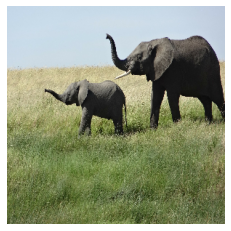

In [48]:
SIZE = (300, 300)
elephants = tf.keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)
elephants = tf.keras.utils.load_img(elephants, target_size=SIZE)
elephants = tf.keras.utils.img_to_array(elephants)
imshow(elephants)

tf.Tensor(0.6977163, shape=(), dtype=float32)
tf.Tensor(0.6977163, shape=(), dtype=float32)


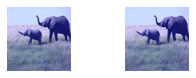

In [60]:
many_elephants = tf.repeat(tf.expand_dims(elephants, axis=0), 2, axis=0)
layer = RandomBlueTint(factor=.5)
augmented = layer(many_elephants)
gallery_show(augmented.numpy())